In [5]:
import numpy as np
import glob2, subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from skimage import exposure
import multiprocessing as mp
import yaml
import warnings

import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import (Conv2D,Dense,Dropout,Flatten,MaxPooling2D,Input)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

## Exploring the dataset

In [2]:
def norm_image(img):
    norm = (img - np.min(img))/(np.max(img) - np.min(img))
#     norm = exposure.equalize_adapthist(norm)
    return norm

class CellData:
    def __init__(self):
        return
    
    def load_xy_from_np(self, npfile):
            
        def load_np(npfile):
            return np.load(npfile, allow_pickle=True)
            
        data = load_np(npfile)
        self.X = norm_image(data['X'][0])
        self.y = data['y'][0]
        self.celltypes = data['cell_types'].item()

    def load_xy(self, X, y):
        if len(X)==1:
            self.X = norm_image(X[0])
            self.y = y[0]
        else:
            self.X = norm_image(X)
            self.y = y
        self.celltypes = None

    def crop_cells(self):
        global proc_image, find_cell
        global X, y, celltypes 
        X = self.X
        y = self.y
        celltypes = self.celltypes
        
        def find_cell(y_index):
            if celltypes is not None:
                label = celltypes[y_index]
            else:
                label = None
            inds_0, inds_1 = np.where(y[:,:,1]==y_index)
            cx = X[min(inds_0):max(inds_0),min(inds_1):max(inds_1),:]
#             cx = np.pad(tmp_x,((0,100-tmp_x.shape[0]), (0,100-tmp_x.shape[1]), (0,0)), mode='constant')
            cy = y_index
            return (cx, cy, label)
        
        with mp.Manager() as manager:
            with manager.Pool(10) as pool:
                unq_indices = np.unique(y[:,:,1])
                unq_indices = np.delete(unq_indices, np.where(unq_indices==0))
                result = pool.map(find_cell, [j for j in unq_indices])
        self.cell_x = [res[0] for res in result]
        self.cell_mask = [res[1] for res in result]
        self.cell_y = [res[2] for res in result]

    def create_marker_expression(self):
        ## loop over all cells to get mean marker expression
        marker_exp = np.zeros((len(self.cell_x),51,17))
        print(marker_exp.shape)
        for i,cell in enumerate(self.cell_x):
            for j in range(51):
                marker_exp[i,j,self.cell_y[i]-1] = np.mean(cell[:,:,j])
        mep = np.mean(marker_exp,axis=0)
        return mep

In [52]:
## Load files one by one so kernel doesn't crash and save cell cutouts in .npy files
npfiles = sorted(glob2.glob('keren/*.npz'))
marker_exp = [] # Also add marker_exp per image to this array
cellcounts = [] # Track distribution of cell types per image
for i,npfile in enumerate(npfiles[0:]): 
    print('Loading ', npfile)
    ind = npfile.split('/')[-1].split('.')[0][-2:]
    cd = CellData()
    try:
        %time cd.load_xy_from_np(npfile)
        %time cd.crop_cells()
        print('-----------------------------------')
        mep = cd.create_marker_expression()
        marker_exp.append(mep)
        k,v = np.unique(cd.cell_y, return_counts=True)
        cellcounts.append({k[i]:v[i] for i in range(len(k))})
    except:
        continue


Loading  keren/Point01.npz
CPU times: user 2.69 s, sys: 1.14 s, total: 3.83 s
Wall time: 3.84 s
CPU times: user 198 ms, sys: 1.13 s, total: 1.33 s
Wall time: 15.7 s
-----------------------------------
(5282, 51, 17)
Loading  keren/Point02.npz
CPU times: user 2.74 s, sys: 1.26 s, total: 4 s
Wall time: 4.02 s
CPU times: user 210 ms, sys: 652 ms, total: 862 ms
Wall time: 9.79 s
-----------------------------------
(3009, 51, 17)
Loading  keren/Point04.npz
CPU times: user 3.15 s, sys: 1.35 s, total: 4.5 s
Wall time: 4.51 s
CPU times: user 349 ms, sys: 2.01 s, total: 2.35 s
Wall time: 22.3 s
-----------------------------------
(6749, 51, 17)
Loading  keren/Point05.npz
CPU times: user 3.24 s, sys: 1.8 s, total: 5.05 s
Wall time: 5.07 s
CPU times: user 252 ms, sys: 1.05 s, total: 1.3 s
Wall time: 15.8 s
-----------------------------------
(5044, 51, 17)
Loading  keren/Point06.npz
CPU times: user 3.19 s, sys: 1.53 s, total: 4.72 s
Wall time: 4.74 s
CPU times: user 327 ms, sys: 1.02 s, total: 1.

KeyError: 5617

-----------------------------------
Loading  keren/Point27.npz
CPU times: user 3.08 s, sys: 551 ms, total: 3.63 s
Wall time: 3.63 s
CPU times: user 246 ms, sys: 896 ms, total: 1.14 s
Wall time: 12.4 s
-----------------------------------
(3790, 51, 17)
Loading  keren/Point28.npz
CPU times: user 3.07 s, sys: 1.43 s, total: 4.49 s
Wall time: 4.5 s
CPU times: user 251 ms, sys: 1.06 s, total: 1.32 s
Wall time: 17.6 s
-----------------------------------
(5902, 51, 17)
Loading  keren/Point29.npz
CPU times: user 3.21 s, sys: 1.04 s, total: 4.24 s
Wall time: 4.26 s
CPU times: user 322 ms, sys: 1.03 s, total: 1.36 s
Wall time: 15.1 s
-----------------------------------
(4678, 51, 17)
Loading  keren/Point30.npz
CPU times: user 3.39 s, sys: 1.59 s, total: 4.98 s
Wall time: 4.98 s
CPU times: user 577 ms, sys: 3.57 s, total: 4.15 s
Wall time: 36.7 s
-----------------------------------
(10502, 51, 17)
Loading  keren/Point31.npz
CPU times: user 3.24 s, sys: 933 ms, total: 4.17 s
Wall time: 4.2 s
CPU t

Text(0.5, 1.0, 'Mask')

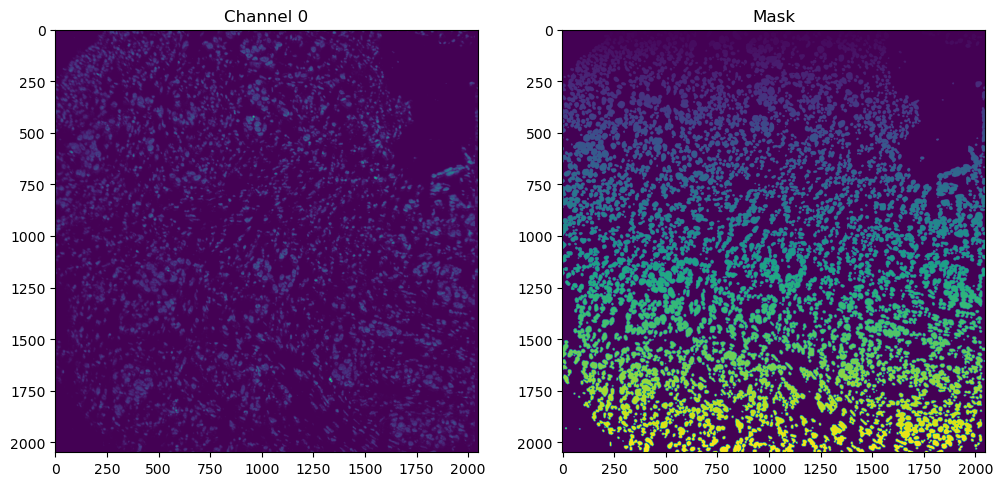

In [55]:
## plot one image mask to check if it loaded correctly
fig,axs = plt.subplots(1,2,figsize=(12,6))
im1 = axs[0].imshow(cd.X[:,:,49])
axs[0].set_title('Channel 0')
im2 = axs[1].imshow(cd.y[:,:,0])
axs[1].set_title('Mask')

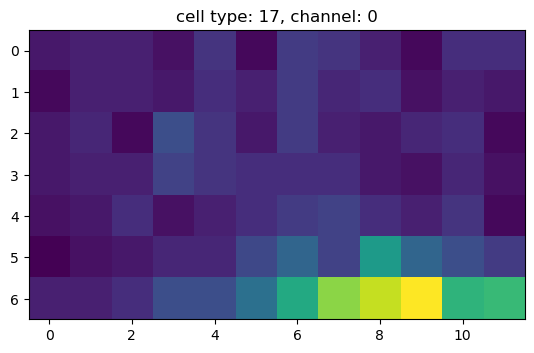

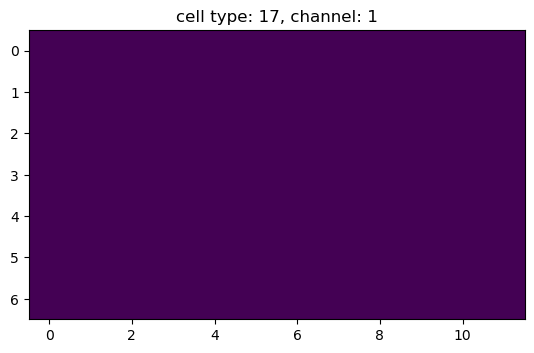

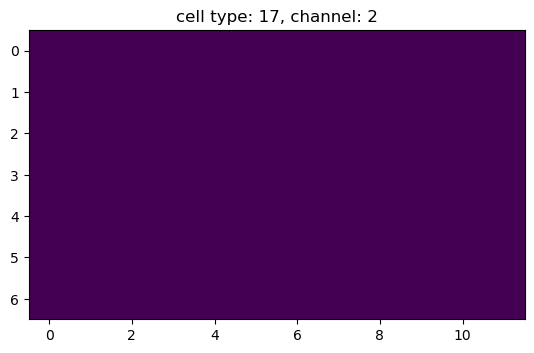

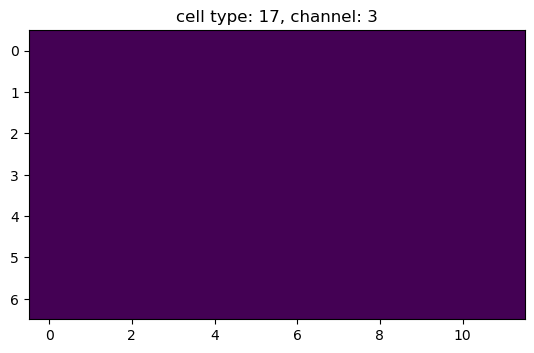

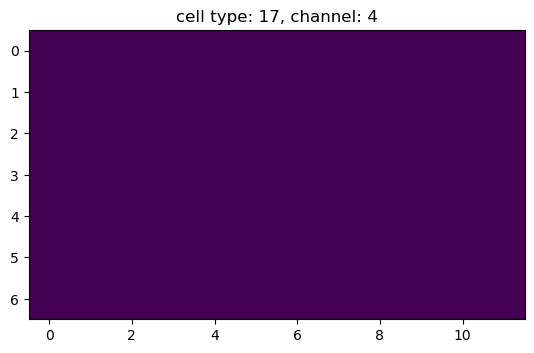

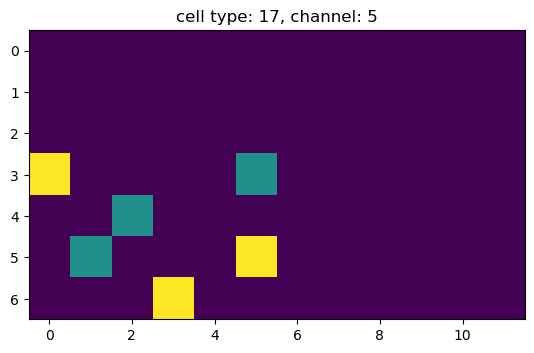

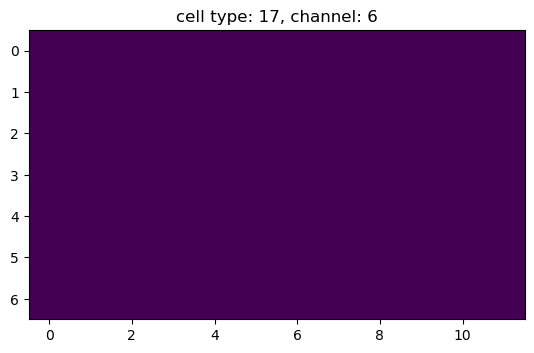

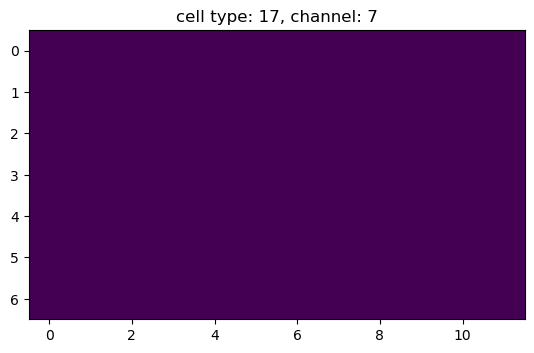

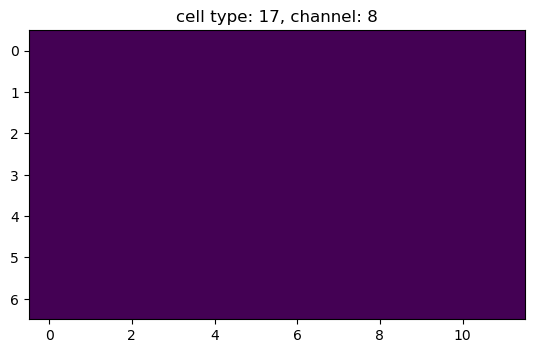

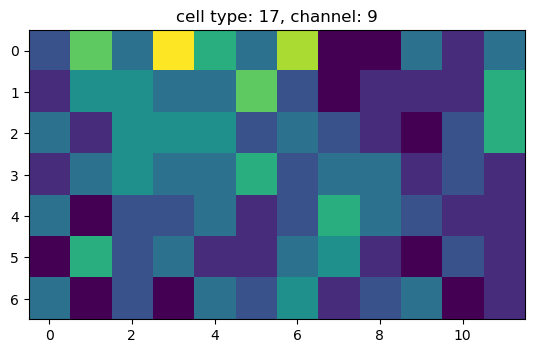

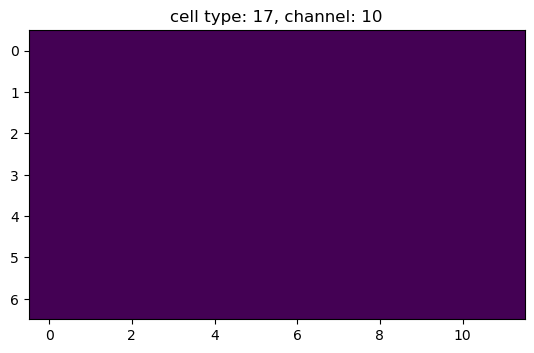

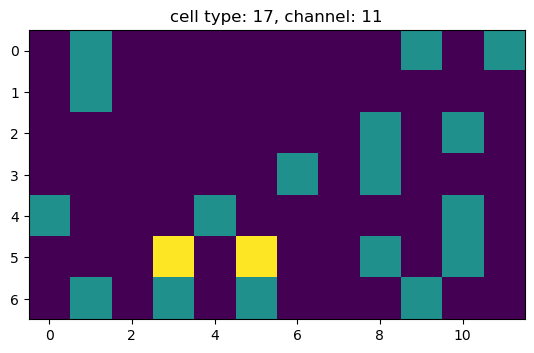

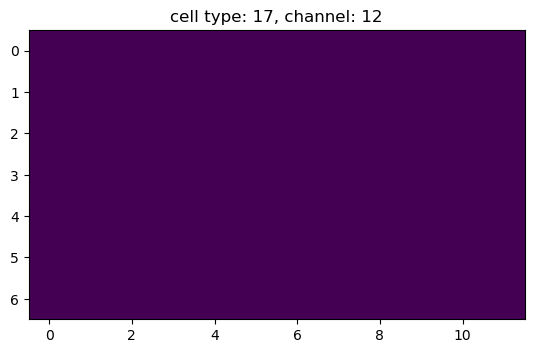

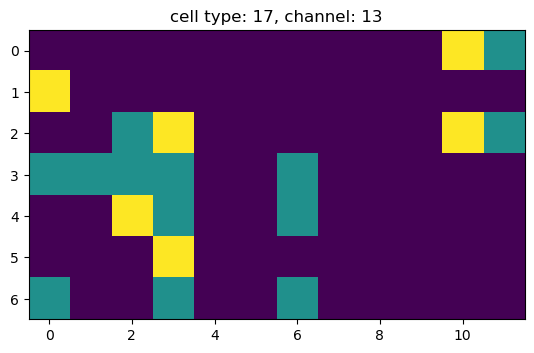

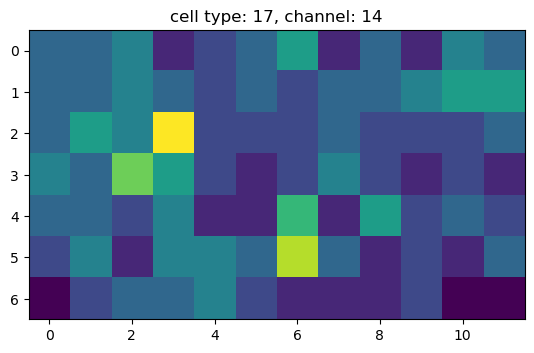

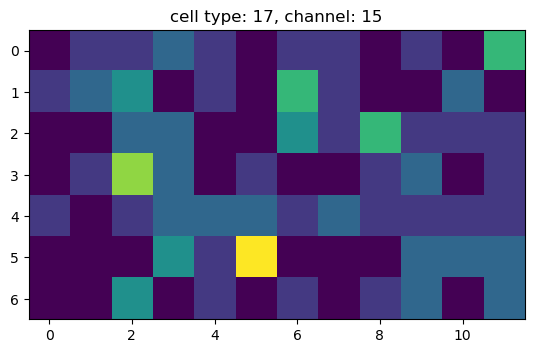

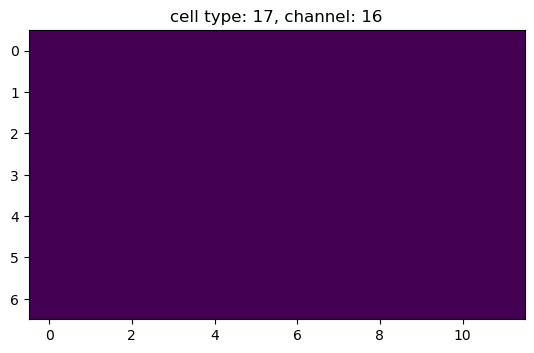

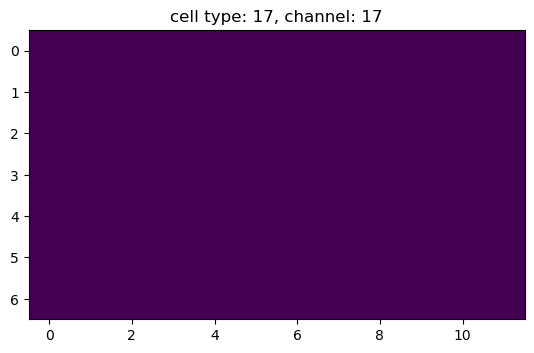

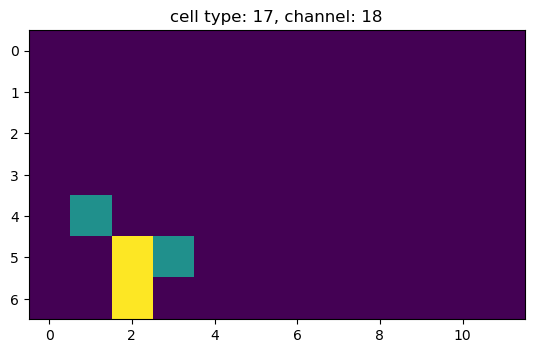

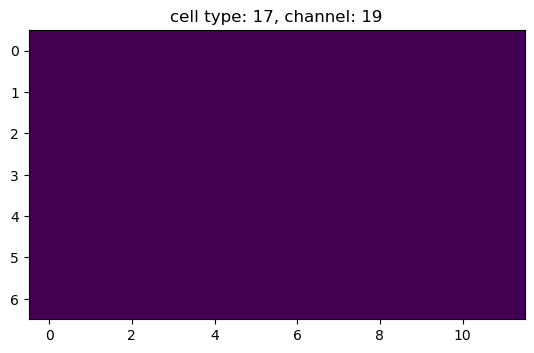

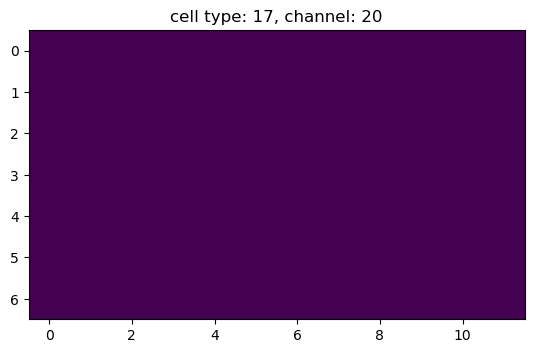

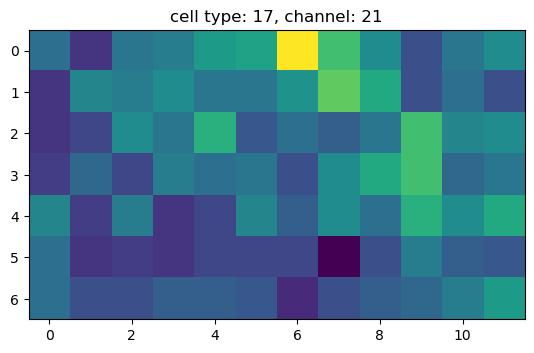

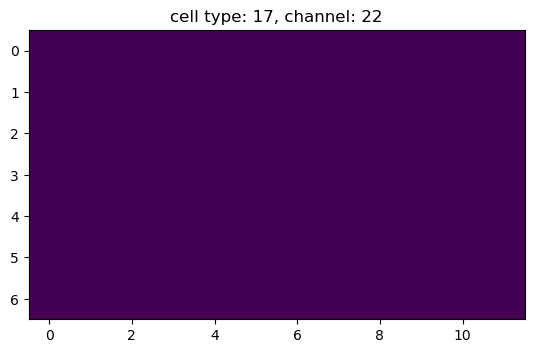

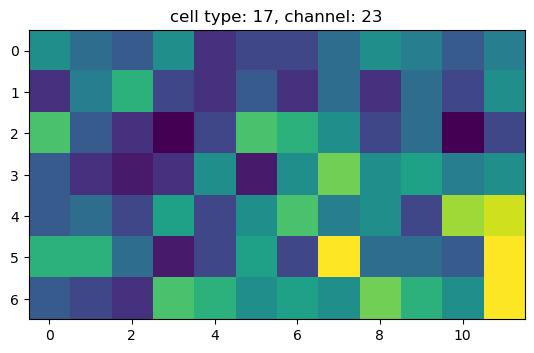

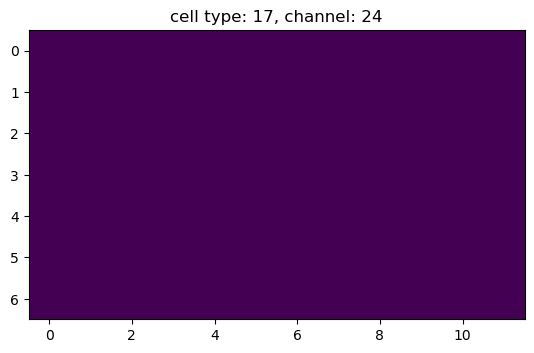

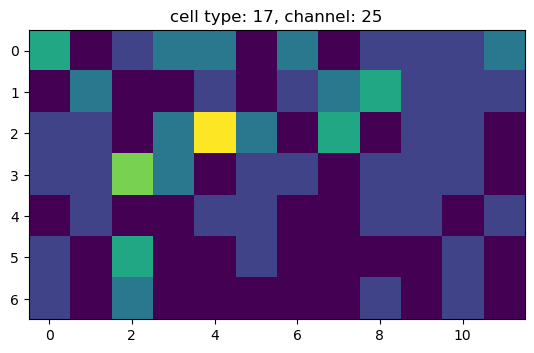

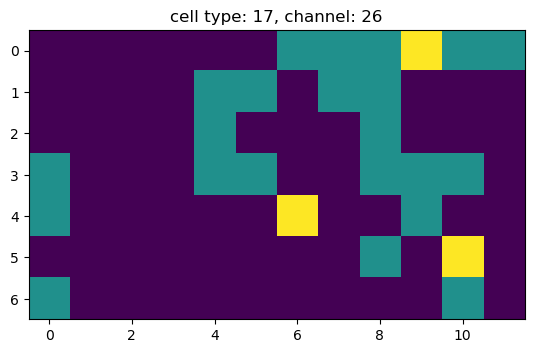

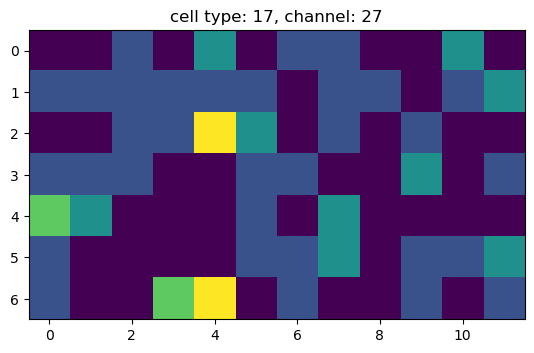

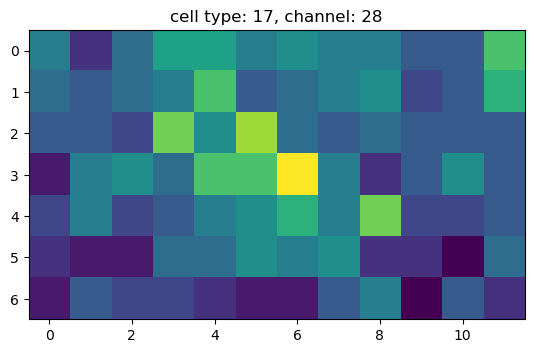

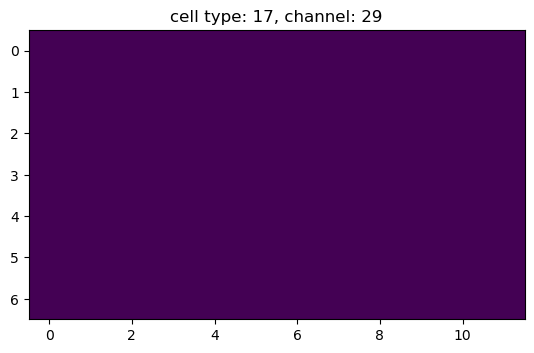

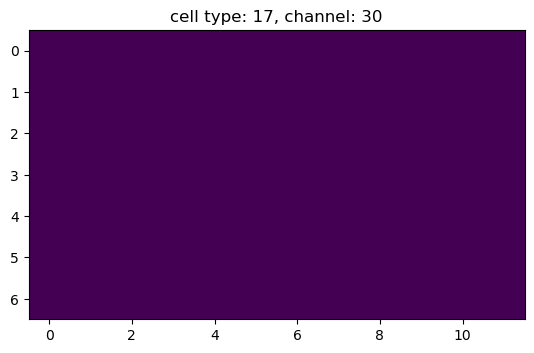

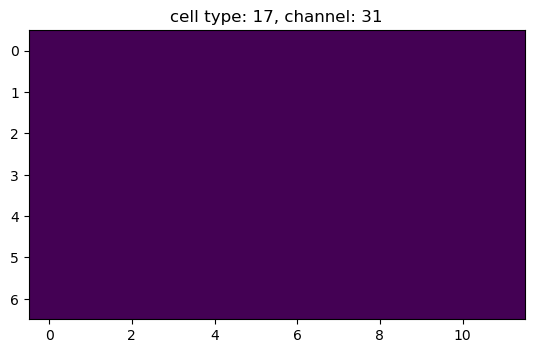

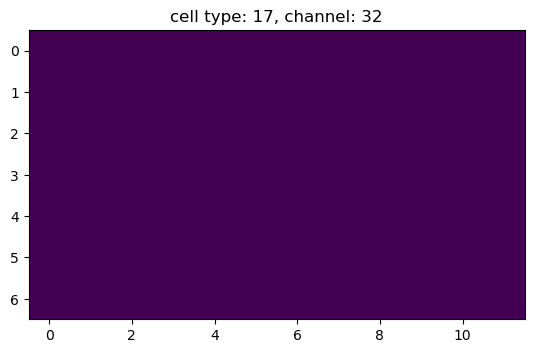

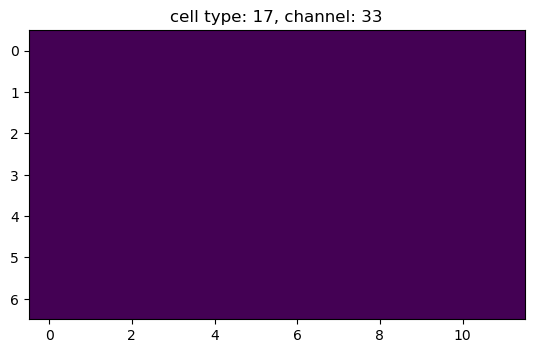

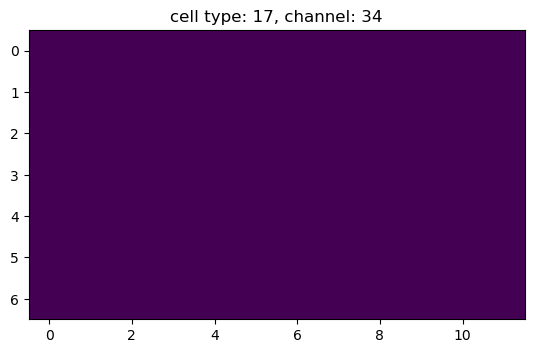

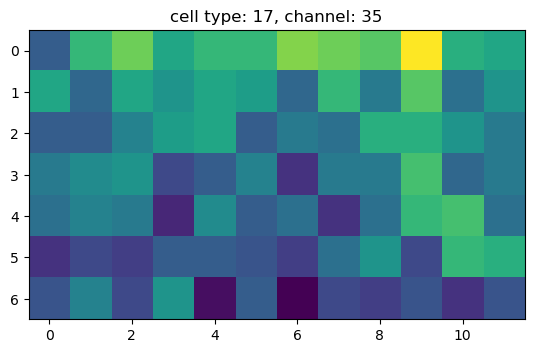

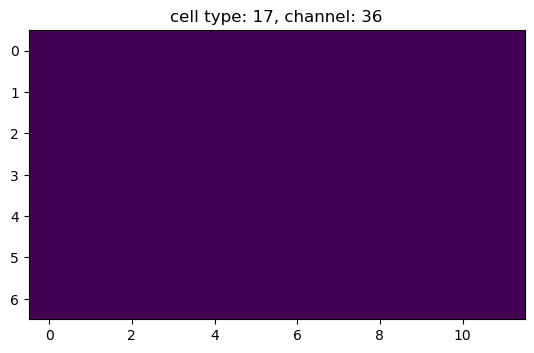

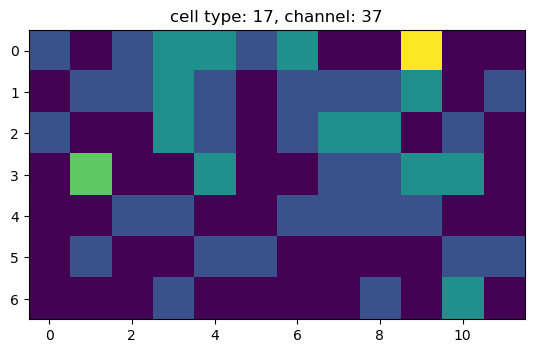

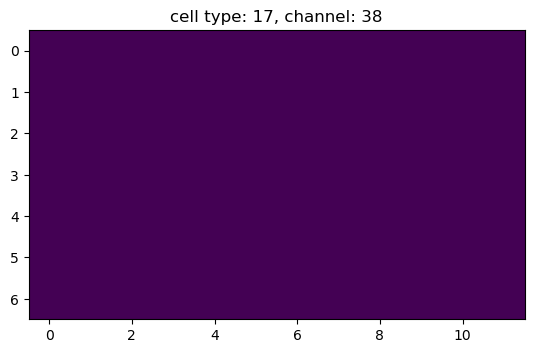

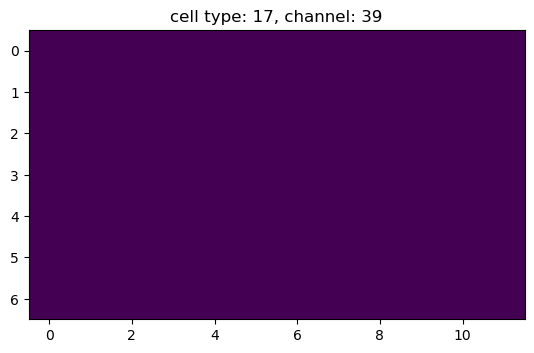

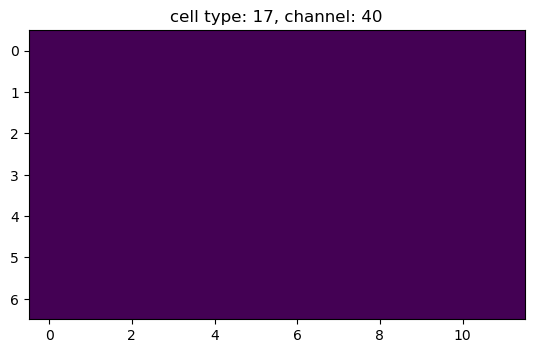

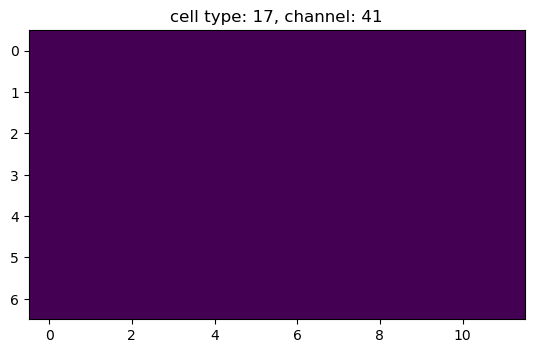

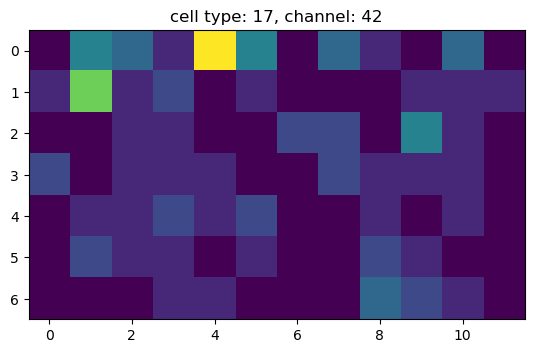

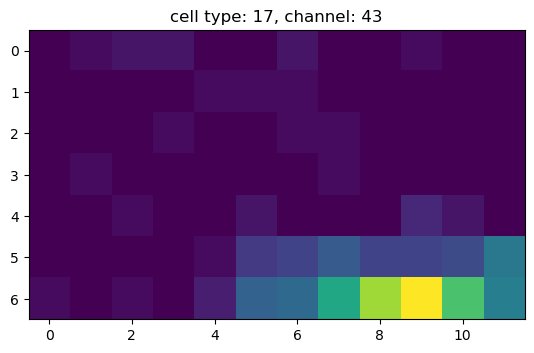

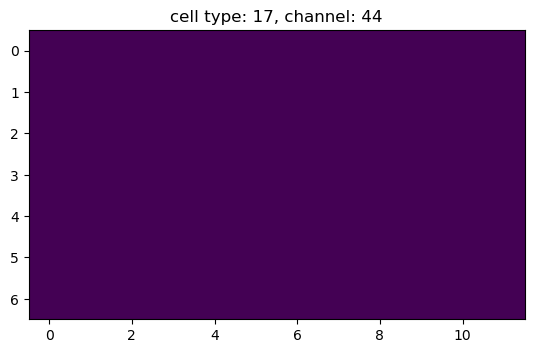

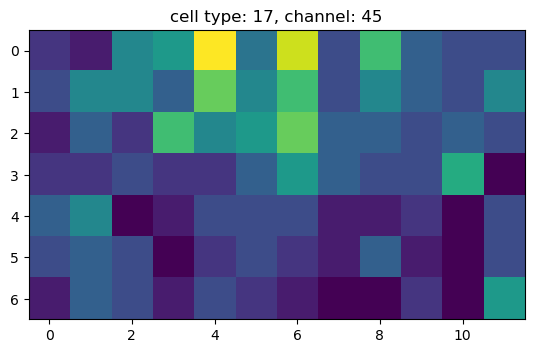

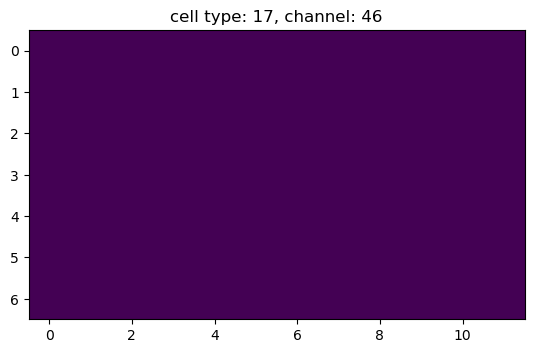

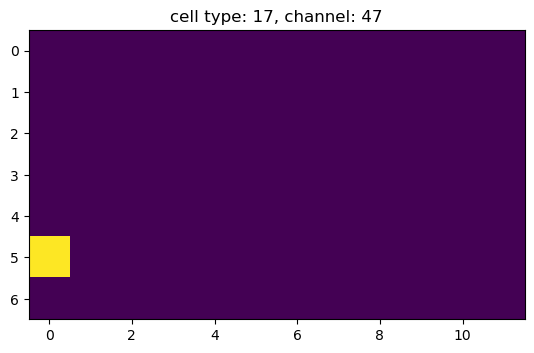

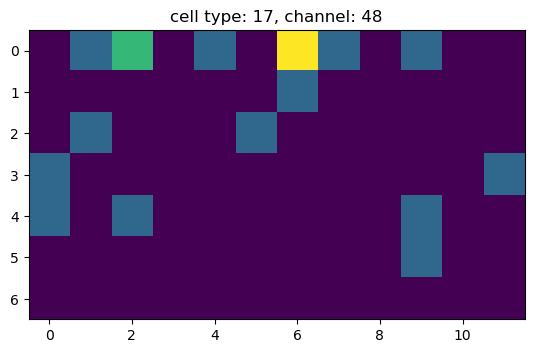

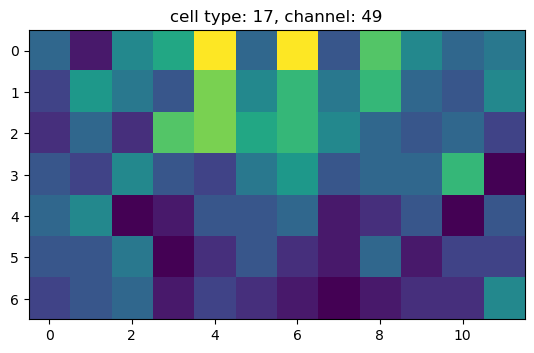

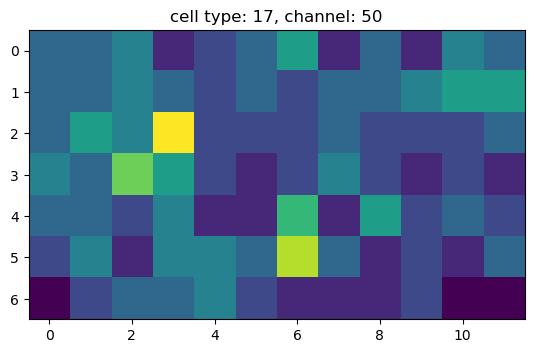

In [56]:
## plot one cropped cell channels
for i in range(51):
    plt.imshow(cd.cell_x[0][:,:,i])
    plt.title(f'cell type: {cd.cell_y[0]}, channel: {i}')
    plt.show()

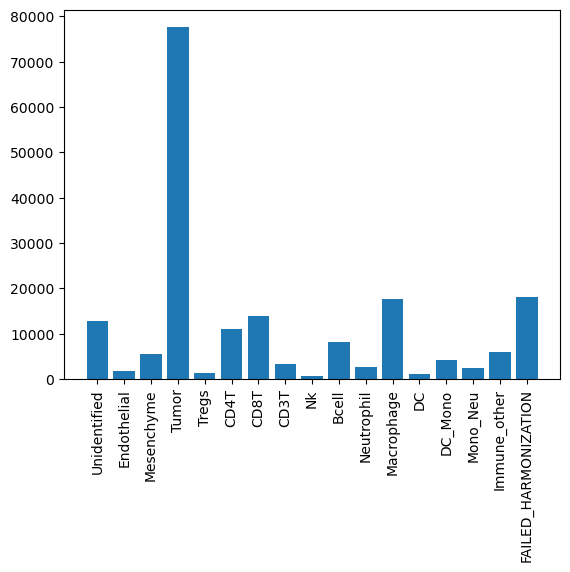

In [57]:
meta = yaml.safe_load(open('keren/meta.yaml','r'))
## plot distribution of cell types
counts = np.zeros(17)
for dct in cellcounts:
    for i in dct.keys():
        counts[i-1] = counts[i-1] + dct[i]
plt.figure()
plt.bar(height=counts,x=np.arange(1,17.1,1).astype(int))
_ = plt.xticks(labels=list(meta['cell_types'].values())[1:], ticks=np.arange(1,17.1,1).astype(int), 
               rotation='vertical')

## Maybe should reduce the classification task to tumor vs non-tumor?

In [58]:
## Take mean of image wise marker expression panels
mep = np.mean(marker_exp,axis=0)

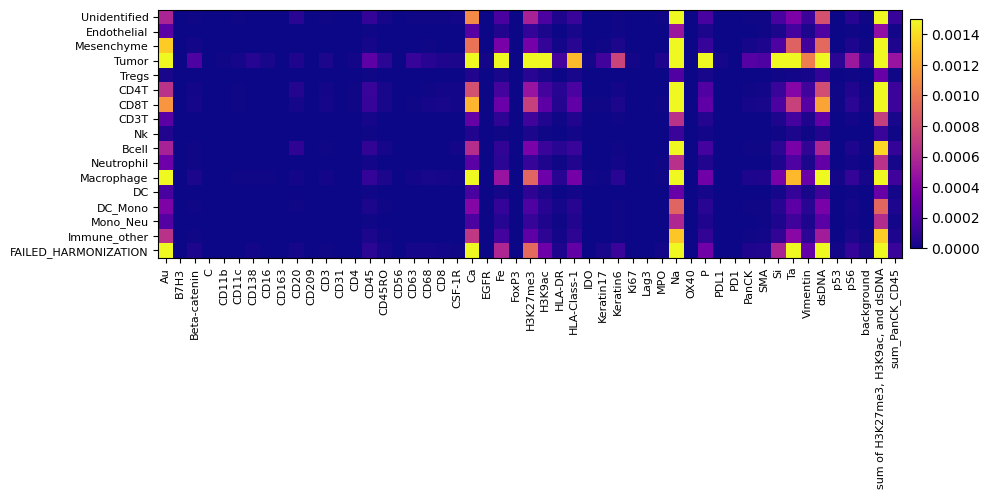

In [59]:
## Plot marker expression panel
mean,std = np.mean(mep), np.std(mep)
fig,ax = plt.subplots(1,1,figsize=(10,6))
im = ax.imshow(mep.transpose(),vmin=0,vmax=mean+std,cmap='plasma')
_ = ax.set_yticks(labels=list(meta['cell_types'].values())[1:],ticks=range(17))
_ = ax.set_xticks(labels=meta['channels'],ticks=range(51),rotation='vertical')
ax.tick_params(labelsize=8)
plt.colorbar(im,ax=ax,fraction=0.015,pad=0.01)
fig.tight_layout()
plt.savefig('marker_exp_panel.png',dpi=200)

Selected channels are  ['Ca', 'Fe', 'H3K27me3', 'H3K9ac', 'Na', 'Si', 'Ta', 'dsDNA', 'sum of H3K27me3, H3K9ac, and dsDNA']


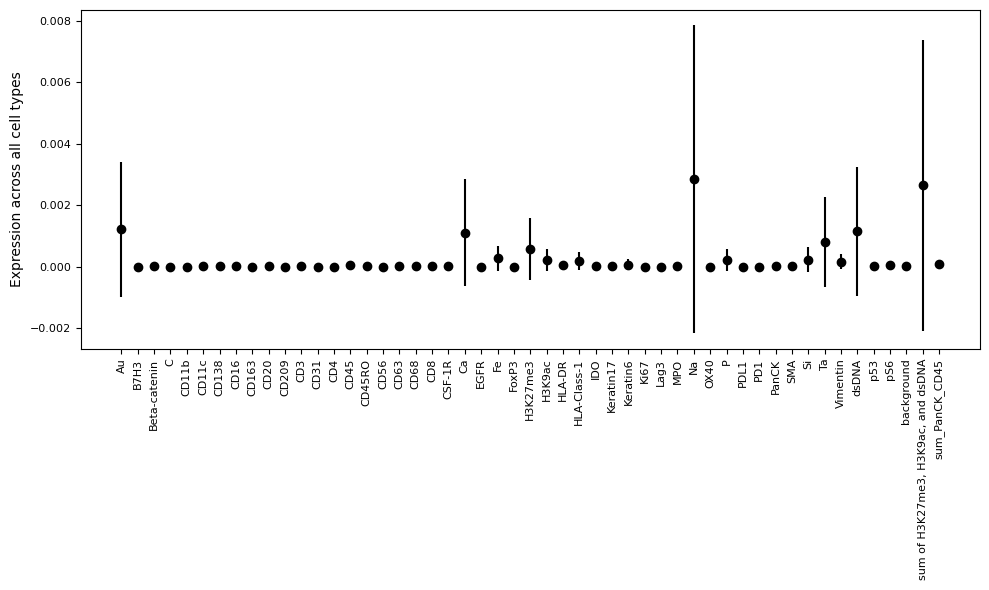

In [62]:
## Mean and std along the cell type axis to plot distribution of total expression per channel
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.errorbar(range(51),np.mean(mep,axis=1),np.std(mep,axis=1),marker='o',color='black',ls='')
# ax.set_yscale('log')
ax.set_ylabel('Expression across all cell types',fontsize=10)
_ = ax.set_xticks(labels=meta['channels'],ticks=range(51),rotation='vertical')
ax.tick_params(labelsize=8)
fig.tight_layout()
#######
# Looking at this figure, channels Ca, Fe, H3K27me3, H3K9ac, Na, Si, Ta, dsDNA and sum of H3K27.. 
# have the most information as well as large spread across cell types (excluding Au, C and P)
global sel_channels
sel_channels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,
                1,1,0,1,0,0,0,1,0]).astype(bool)
print('Selected channels are ', [x for x in np.array(meta['channels'])[sel_channels]])

9

## CNN model training

In [7]:
meta = yaml.safe_load(open('keren/meta.yaml','r'))
global sel_channels
sel_channels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,
                1,1,0,1,0,0,0,1,0]).astype(bool)
print('Number of channels used ',len(np.array(meta['channels'])[sel_channels]))

class Model:
    def __init__(self,inp_shape, num_classes):
        self.inp_shape = inp_shape
        self.num_classes = num_classes
        
    def build_model(self):
        if self.num_classes == 1:
            act = 'sigmoid'
        else:
            act = 'softmax'
        print(act)
        inp = Input(shape=self.inp_shape)
        x = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(inp)
#         x = Dropout(0.1)(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(x)
#         x = Dropout(0.1)(x)
        x = MaxPooling2D((2,2))(x)
#         x = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(x)
# #         x = Dropout(0.1)(x)
#         x = MaxPooling2D((2,2))(x)
        x = Flatten()(x)
        x = Dense(256,activation='relu')(x)
#         x = Dropout(0.1)(x)
        x = Dense(64,activation='relu')(x)
        out = Dense(self.num_classes,activation=act)(x)
        self.model = keras.Model(inputs=inp,outputs=out)
        
    def compile_model(self,opt='adam',lr=1e-3,momentum=0.9):
        if opt=='adam':
            opt_choice = optimizers.Adam(lr=lr)
        elif opt=='sgd':
            opt_choice = optimizers.SGD(lr=lr,momentum=momentum)
        elif opt=='adagrad':
            opt_choice = optimizers.Adagrad(lr=lr)
        else:
            opt_choice = 'adam'
        
        if self.num_classes == 1:
            loss_choice = 'binary_crossentropy'
        else:
            loss_choice = 'categorical_crossentropy'
        print(loss_choice)
        self.model.compile(optimizer=opt_choice,loss=loss_choice,
                           metrics=['accuracy'])
        
def train_model(model, xtrain, ytrain, epochs=30, batch_size=32):        
    earlystop_callback = keras.callbacks.EarlyStopping(monitor='loss',patience=10)
    model.fit(xtrain, ytrain, validation_split=0.3, 
                epochs=epochs, batch_size=batch_size,callbacks = [earlystop_callback], verbose=2)
    return model
        

def prep_samples(cell_x, cell_y, sel_channels, cell_height=50, cell_width=50):
    ## Using resize with pad instead of padding to a bounding box as it nicely samples and enhances the images
    padded_x = []
    for cell in cell_x:
        padded_x.append(tf.image.resize_with_pad(cell[:,:,sel_channels],target_height=cell_height,
                                                 target_width=cell_width))
#     xtrain, xtest, ytrain, ytest = train_test_split(padded_x, cell_y, shuffle=True, test_size=0.2,
#                                                    random_state=1)
    xtrain = tf.convert_to_tensor(padded_x)
#     xtest = tf.convert_to_tensor(xtest)
    ytrain = to_categorical(np.array(cell_y).astype(int)-1,num_classes=17)
#   ytest = to_categorical(np.array(ytest).astype(int)-1,num_classes=17)
    return xtrain, ytrain
    
##############################################################################################################
##############################################################################################################

# Function to process test data and run it through model

def test_model(X,y,cell_height=40,cell_width=40):
    cd = CellData()
    print('Loading data')
    cd.load_xy(X,y)
    print('Cropping cells')
    cd.crop_cells()
    meta = yaml.safe_load(open('keren/meta.yaml','r'))
    sel_channels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,
                1,1,0,1,0,0,0,1,0]).astype(bool)
    print('Processing data')
    padded_x = []
    for cell in cd.cell_x:
        padded_x.append(tf.image.resize_with_pad(cell[:,:,sel_channels],target_height=cell_height,
                                                 target_width=cell_width))
    xtest = tf.convert_to_tensor(padded_x)
    
    print('Loading model')
    subprocess.call(f'wget https://sites.astro.caltech.edu/~yssharma/cellmodel.tar.xz',shell=True)
    subprocess.call(f'tar -xvf cellmodel.tar.xz',shell=True)
    model = keras.models.load_model('cellmodel',compile=True)
    print('Making predictions')
    preds = np.argmax(model.predict(xtest),axis=-1)
    result = {}
    for i in range(len(preds)):
        result[cd.cell_mask[i]] = preds[i]+1
    return result

###############################################################################################################
###############################################################################################################

Number of channels used  9


In [13]:
## Build and compile model
m = Model(inp_shape=(40,40,len(np.array(meta['channels'])[sel_channels])), num_classes=17)
m.build_model()
m.compile_model(opt='adam',lr=0.001)
model = m.model
model.summary()

softmax
categorical_crossentropy
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 9)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 38, 38, 32)        2624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)      

In [14]:
result = []
## Load files one by one and train model so kernel doesn't crash
npfiles = sorted(glob2.glob('keren/Point*.npz'))

In [15]:
for i,npfile in enumerate(npfiles[0:10]): 
    if '26' in npfile:
        continue
    print('Loading ', npfile)
    cd = CellData()
    %time cd.load_xy_from_np(npfile)
    %time cd.crop_cells()
    ## train further split into 70:30 (train:val) in model.fit()
    %time xtrain,ytrain = prep_samples(cd.cell_x,cd.cell_y,sel_channels,40,40)
    print('-----------------------------------')
    model = train_model(model, xtrain, ytrain, epochs=50, batch_size=16)
#     result.append(model.evaluate(xtest, ytest))
    print('Finished training ', npfile)

Loading  keren/Point01.npz
CPU times: user 2.73 s, sys: 671 ms, total: 3.4 s
Wall time: 3.43 s
CPU times: user 341 ms, sys: 1.05 s, total: 1.39 s
Wall time: 15.5 s
CPU times: user 26.3 s, sys: 1.26 s, total: 27.5 s
Wall time: 20.2 s
-----------------------------------
Epoch 1/50
232/232 - 2s - loss: 1.8477 - accuracy: 0.5196 - val_loss: 2.2319 - val_accuracy: 0.2555 - 2s/epoch - 7ms/step
Epoch 2/50
232/232 - 1s - loss: 1.7841 - accuracy: 0.5212 - val_loss: 2.3812 - val_accuracy: 0.2555 - 979ms/epoch - 4ms/step
Epoch 3/50
232/232 - 1s - loss: 1.7737 - accuracy: 0.5204 - val_loss: 2.2303 - val_accuracy: 0.2555 - 744ms/epoch - 3ms/step
Epoch 4/50
232/232 - 1s - loss: 1.7731 - accuracy: 0.5218 - val_loss: 2.2482 - val_accuracy: 0.2555 - 819ms/epoch - 4ms/step
Epoch 5/50
232/232 - 1s - loss: 1.7726 - accuracy: 0.5207 - val_loss: 2.1916 - val_accuracy: 0.2555 - 758ms/epoch - 3ms/step
Epoch 6/50
232/232 - 1s - loss: 1.7660 - accuracy: 0.5218 - val_loss: 2.3599 - val_accuracy: 0.2555 - 808ms/e

Epoch 12/50
132/132 - 0s - loss: 1.3642 - accuracy: 0.5408 - val_loss: 2.1060 - val_accuracy: 0.4939 - 390ms/epoch - 3ms/step
Epoch 13/50
132/132 - 0s - loss: 1.3227 - accuracy: 0.5494 - val_loss: 2.1817 - val_accuracy: 0.4806 - 439ms/epoch - 3ms/step
Epoch 14/50
132/132 - 0s - loss: 1.2828 - accuracy: 0.5570 - val_loss: 2.2069 - val_accuracy: 0.4862 - 392ms/epoch - 3ms/step
Epoch 15/50
132/132 - 0s - loss: 1.2445 - accuracy: 0.5698 - val_loss: 2.2252 - val_accuracy: 0.4928 - 452ms/epoch - 3ms/step
Epoch 16/50
132/132 - 0s - loss: 1.1972 - accuracy: 0.5807 - val_loss: 2.3007 - val_accuracy: 0.4718 - 485ms/epoch - 4ms/step
Epoch 17/50
132/132 - 0s - loss: 1.1297 - accuracy: 0.6021 - val_loss: 2.3697 - val_accuracy: 0.4828 - 449ms/epoch - 3ms/step
Epoch 18/50
132/132 - 0s - loss: 1.0695 - accuracy: 0.6192 - val_loss: 2.3698 - val_accuracy: 0.4374 - 379ms/epoch - 3ms/step
Epoch 19/50
132/132 - 0s - loss: 0.9991 - accuracy: 0.6553 - val_loss: 2.3977 - val_accuracy: 0.4551 - 482ms/epoch - 4

296/296 - 1s - loss: 1.4776 - accuracy: 0.5074 - val_loss: 3.7156 - val_accuracy: 0.1911 - 1s/epoch - 4ms/step
Epoch 26/50
296/296 - 1s - loss: 1.3769 - accuracy: 0.5413 - val_loss: 3.8448 - val_accuracy: 0.2123 - 948ms/epoch - 3ms/step
Epoch 27/50
296/296 - 1s - loss: 1.2862 - accuracy: 0.5667 - val_loss: 4.1712 - val_accuracy: 0.2010 - 1s/epoch - 3ms/step
Epoch 28/50
296/296 - 1s - loss: 1.1988 - accuracy: 0.6012 - val_loss: 4.6771 - val_accuracy: 0.1916 - 1s/epoch - 4ms/step
Epoch 29/50
296/296 - 1s - loss: 1.1034 - accuracy: 0.6310 - val_loss: 4.9252 - val_accuracy: 0.1965 - 964ms/epoch - 3ms/step
Epoch 30/50
296/296 - 1s - loss: 1.0330 - accuracy: 0.6649 - val_loss: 4.9186 - val_accuracy: 0.1886 - 997ms/epoch - 3ms/step
Epoch 31/50
296/296 - 1s - loss: 0.9396 - accuracy: 0.6888 - val_loss: 5.6606 - val_accuracy: 0.1788 - 1s/epoch - 3ms/step
Epoch 32/50
296/296 - 1s - loss: 0.8586 - accuracy: 0.7136 - val_loss: 5.6536 - val_accuracy: 0.1743 - 1s/epoch - 4ms/step
Epoch 33/50
296/296

Epoch 39/50
221/221 - 1s - loss: 1.8352 - accuracy: 0.3836 - val_loss: 2.8428 - val_accuracy: 0.3514 - 712ms/epoch - 3ms/step
Epoch 40/50
221/221 - 1s - loss: 1.8211 - accuracy: 0.3850 - val_loss: 3.2249 - val_accuracy: 0.3402 - 749ms/epoch - 3ms/step
Epoch 41/50
221/221 - 1s - loss: 1.8058 - accuracy: 0.3856 - val_loss: 3.0136 - val_accuracy: 0.3653 - 854ms/epoch - 4ms/step
Epoch 42/50
221/221 - 1s - loss: 1.8098 - accuracy: 0.3833 - val_loss: 3.1282 - val_accuracy: 0.3527 - 743ms/epoch - 3ms/step
Epoch 43/50
221/221 - 1s - loss: 1.7757 - accuracy: 0.3929 - val_loss: 3.1602 - val_accuracy: 0.3507 - 715ms/epoch - 3ms/step
Epoch 44/50
221/221 - 1s - loss: 1.7556 - accuracy: 0.3986 - val_loss: 3.2888 - val_accuracy: 0.3309 - 721ms/epoch - 3ms/step
Epoch 45/50
221/221 - 1s - loss: 1.7323 - accuracy: 0.4040 - val_loss: 3.3607 - val_accuracy: 0.3045 - 797ms/epoch - 4ms/step
Epoch 46/50
221/221 - 1s - loss: 1.7423 - accuracy: 0.4028 - val_loss: 3.4907 - val_accuracy: 0.3534 - 707ms/epoch - 3

CPU times: user 212 ms, sys: 1.07 s, total: 1.28 s
Wall time: 13.3 s
CPU times: user 19.8 s, sys: 951 ms, total: 20.7 s
Wall time: 15.6 s
-----------------------------------
Epoch 1/50
150/150 - 1s - loss: 1.6722 - accuracy: 0.6174 - val_loss: 1.2255 - val_accuracy: 0.6680 - 664ms/epoch - 4ms/step
Epoch 2/50
150/150 - 0s - loss: 1.2916 - accuracy: 0.6249 - val_loss: 1.2029 - val_accuracy: 0.6680 - 464ms/epoch - 3ms/step
Epoch 3/50
150/150 - 1s - loss: 1.2588 - accuracy: 0.6258 - val_loss: 1.2098 - val_accuracy: 0.6680 - 506ms/epoch - 3ms/step
Epoch 4/50
150/150 - 1s - loss: 1.2504 - accuracy: 0.6254 - val_loss: 1.1860 - val_accuracy: 0.6680 - 583ms/epoch - 4ms/step
Epoch 5/50
150/150 - 1s - loss: 1.2426 - accuracy: 0.6254 - val_loss: 1.1943 - val_accuracy: 0.6680 - 555ms/epoch - 4ms/step
Epoch 6/50
150/150 - 0s - loss: 1.2311 - accuracy: 0.6254 - val_loss: 1.2173 - val_accuracy: 0.6680 - 459ms/epoch - 3ms/step
Epoch 7/50
150/150 - 1s - loss: 1.2284 - accuracy: 0.6258 - val_loss: 1.1975

Epoch 13/50
175/175 - 1s - loss: 1.4361 - accuracy: 0.5016 - val_loss: 2.0420 - val_accuracy: 0.3161 - 615ms/epoch - 4ms/step
Epoch 14/50
175/175 - 1s - loss: 1.4239 - accuracy: 0.5041 - val_loss: 2.0725 - val_accuracy: 0.3177 - 542ms/epoch - 3ms/step
Epoch 15/50
175/175 - 1s - loss: 1.4157 - accuracy: 0.5056 - val_loss: 2.0917 - val_accuracy: 0.3161 - 613ms/epoch - 4ms/step
Epoch 16/50
175/175 - 1s - loss: 1.4024 - accuracy: 0.5088 - val_loss: 2.2209 - val_accuracy: 0.3152 - 614ms/epoch - 4ms/step
Epoch 17/50
175/175 - 1s - loss: 1.3887 - accuracy: 0.5084 - val_loss: 2.1169 - val_accuracy: 0.3094 - 675ms/epoch - 4ms/step
Epoch 18/50
175/175 - 1s - loss: 1.3710 - accuracy: 0.5156 - val_loss: 2.1331 - val_accuracy: 0.3002 - 614ms/epoch - 4ms/step
Epoch 19/50
175/175 - 1s - loss: 1.3528 - accuracy: 0.5203 - val_loss: 2.2077 - val_accuracy: 0.3119 - 710ms/epoch - 4ms/step
Epoch 20/50
175/175 - 1s - loss: 1.3278 - accuracy: 0.5274 - val_loss: 2.2231 - val_accuracy: 0.3018 - 702ms/epoch - 4

Epoch 26/50
248/248 - 1s - loss: 2.0742 - accuracy: 0.3296 - val_loss: 2.0475 - val_accuracy: 0.4529 - 952ms/epoch - 4ms/step
Epoch 27/50
248/248 - 1s - loss: 2.0751 - accuracy: 0.3276 - val_loss: 1.9910 - val_accuracy: 0.4817 - 853ms/epoch - 3ms/step
Epoch 28/50
248/248 - 1s - loss: 2.0604 - accuracy: 0.3311 - val_loss: 1.9580 - val_accuracy: 0.5077 - 843ms/epoch - 3ms/step
Epoch 29/50
248/248 - 1s - loss: 2.0527 - accuracy: 0.3304 - val_loss: 2.0950 - val_accuracy: 0.4111 - 820ms/epoch - 3ms/step
Epoch 30/50
248/248 - 1s - loss: 2.0508 - accuracy: 0.3370 - val_loss: 1.9961 - val_accuracy: 0.4894 - 814ms/epoch - 3ms/step
Epoch 31/50
248/248 - 1s - loss: 2.0422 - accuracy: 0.3377 - val_loss: 2.1183 - val_accuracy: 0.4464 - 951ms/epoch - 4ms/step
Epoch 32/50
248/248 - 1s - loss: 2.0198 - accuracy: 0.3385 - val_loss: 2.1907 - val_accuracy: 0.4711 - 814ms/epoch - 3ms/step
Epoch 33/50
248/248 - 1s - loss: 2.0151 - accuracy: 0.3471 - val_loss: 2.2290 - val_accuracy: 0.3969 - 948ms/epoch - 4

Epoch 39/50
190/190 - 1s - loss: 1.8586 - accuracy: 0.3326 - val_loss: 2.1802 - val_accuracy: 0.2413 - 612ms/epoch - 3ms/step
Epoch 40/50
190/190 - 1s - loss: 1.8469 - accuracy: 0.3379 - val_loss: 2.2634 - val_accuracy: 0.2675 - 683ms/epoch - 4ms/step
Epoch 41/50
190/190 - 1s - loss: 1.8358 - accuracy: 0.3438 - val_loss: 2.2711 - val_accuracy: 0.2390 - 662ms/epoch - 3ms/step
Epoch 42/50
190/190 - 1s - loss: 1.8249 - accuracy: 0.3455 - val_loss: 2.3167 - val_accuracy: 0.2344 - 721ms/epoch - 4ms/step
Epoch 43/50
190/190 - 1s - loss: 1.8174 - accuracy: 0.3418 - val_loss: 2.3602 - val_accuracy: 0.2398 - 655ms/epoch - 3ms/step
Epoch 44/50
190/190 - 1s - loss: 1.7969 - accuracy: 0.3481 - val_loss: 2.4492 - val_accuracy: 0.2429 - 714ms/epoch - 4ms/step
Epoch 45/50
190/190 - 1s - loss: 1.7933 - accuracy: 0.3560 - val_loss: 2.3620 - val_accuracy: 0.2298 - 665ms/epoch - 3ms/step
Epoch 46/50
190/190 - 1s - loss: 1.7766 - accuracy: 0.3593 - val_loss: 2.4068 - val_accuracy: 0.2429 - 600ms/epoch - 3

In [16]:
model.save('cellmodel')

INFO:tensorflow:Assets written to: cellmodel/assets


INFO:tensorflow:Assets written to: cellmodel/assets


### Test model

In [17]:
cell_x, cell_y = [],[]
for i,npfile in enumerate(npfiles[10:12]): 
    print('Loading ', npfile)
    cd = CellData()
    %time cd.load_xy_from_np(npfile)
    %time cd.crop_cells()
    print('-----------------------------------')
    cell_x = cell_x + cd.cell_x
    cell_y = cell_y + cd.cell_y # this is the cell type label
    
padded_x = []
for cell in cell_x:
    padded_x.append(tf.image.resize_with_pad(cell[:,:,sel_channels],target_height=40,
                                             target_width=40))
xtest = tf.convert_to_tensor(padded_x)
ytest = to_categorical(np.array(cell_y).astype(int)-1,num_classes=17)

preds = np.argmax(model.predict(xtest),axis=-1)

Loading  keren/Point12.npz
CPU times: user 3.44 s, sys: 1.62 s, total: 5.05 s
Wall time: 5.08 s
CPU times: user 403 ms, sys: 2.05 s, total: 2.45 s
Wall time: 23 s
-----------------------------------
Loading  keren/Point13.npz
CPU times: user 3.2 s, sys: 1.69 s, total: 4.9 s
Wall time: 4.91 s
CPU times: user 330 ms, sys: 1.35 s, total: 1.68 s
Wall time: 24.3 s
-----------------------------------
447/447 [==============================] - 1s 2ms/step


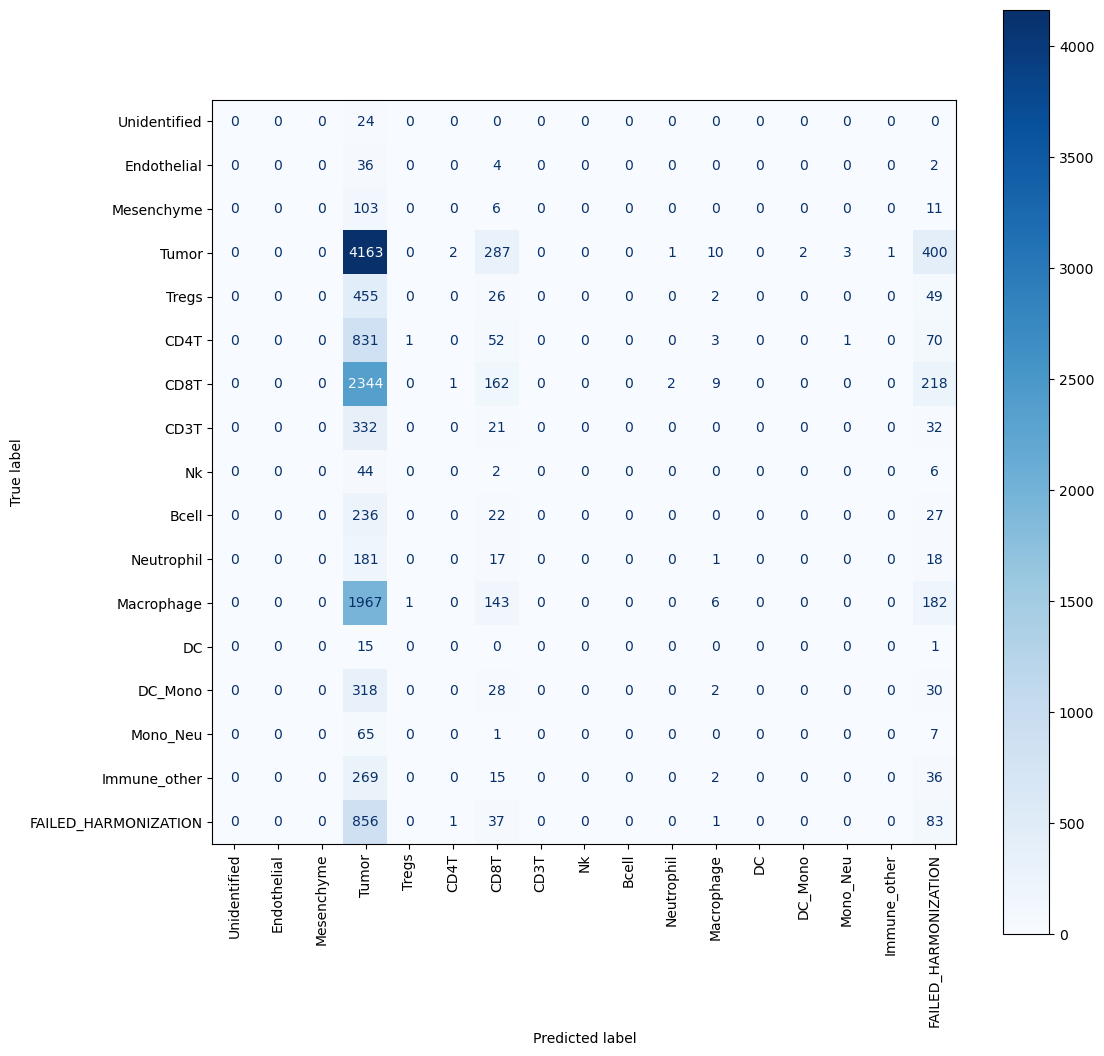

In [29]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
cm = confusion_matrix(cell_y,preds+1,labels=list(meta['cell_types'].keys())[1:])
disp = ConfusionMatrixDisplay(cm,display_labels=list(meta['cell_types'].values())[1:])
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.xticks(rotation='vertical')
plt.savefig('conmat.png',dpi=200)

# test_model function 

In [8]:
## Loading sample data
cdt = CellData()
cdt.load_xy_from_np('keren/Point30.npz')
## test_model takes X, y and resized cropped cell dimension (model trained on 40x40)
res = test_model(cdt.X,cdt.y,40,40)

Loading data
Cropping cells
Processing data
Loading model


--2023-04-21 15:42:49--  https://sites.astro.caltech.edu/~yssharma/cellmodel.tar.xz
Resolving sites.astro.caltech.edu (sites.astro.caltech.edu)... 131.215.198.54
Connecting to sites.astro.caltech.edu (sites.astro.caltech.edu)|131.215.198.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5652188 (5.4M) [application/x-xz]
Saving to: ‘cellmodel.tar.xz.1’

     0K .......... .......... .......... .......... ..........  0%  724K 8s
    50K .......... .......... .......... .......... ..........  1% 62.4M 4s
   100K .......... .......... .......... .......... ..........  2% 2.19M 3s
   150K .......... .......... .......... .......... ..........  3% 56.9M 2s
   200K .......... .......... .......... .......... ..........  4% 94.0M 2s
   250K .......... .......... .......... .......... ..........  5% 1.98M 2s
   300K .......... .......... .......... .......... ..........  6% 36.3M 2s
   350K .......... .......... .......... .......... ..........  7% 36.5M 2s
   400K ..

cellmodel/
cellmodel/variables/
cellmodel/variables/variables.data-00000-of-00001
cellmodel/variables/variables.index
cellmodel/assets/
cellmodel/fingerprint.pb
cellmodel/saved_model.pb
cellmodel/keras_metadata.pb
Making predictions


2023-04-21 15:42:51.161103: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 604915200 exceeds 10% of free system memory.


329/329 [==============================] - 1s 2ms/step


In [10]:
res

{1: 4,
 2: 17,
 3: 17,
 4: 17,
 5: 17,
 6: 17,
 7: 17,
 8: 4,
 9: 17,
 10: 4,
 11: 17,
 12: 17,
 13: 4,
 14: 4,
 15: 17,
 16: 4,
 17: 4,
 18: 17,
 19: 4,
 20: 4,
 21: 4,
 22: 17,
 23: 4,
 24: 4,
 25: 4,
 26: 4,
 27: 4,
 28: 4,
 29: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 17,
 35: 4,
 36: 4,
 37: 17,
 38: 4,
 39: 4,
 40: 4,
 41: 4,
 42: 4,
 43: 4,
 44: 4,
 45: 4,
 46: 4,
 47: 4,
 48: 4,
 49: 4,
 50: 4,
 51: 4,
 52: 4,
 53: 4,
 54: 17,
 55: 4,
 56: 4,
 57: 4,
 58: 4,
 59: 4,
 60: 4,
 61: 4,
 62: 4,
 63: 17,
 64: 17,
 65: 4,
 66: 4,
 67: 4,
 68: 4,
 69: 4,
 70: 4,
 71: 4,
 72: 4,
 73: 4,
 74: 4,
 75: 17,
 76: 17,
 77: 4,
 78: 4,
 79: 4,
 80: 4,
 81: 4,
 82: 4,
 83: 4,
 84: 4,
 85: 4,
 86: 4,
 87: 4,
 88: 4,
 89: 4,
 90: 4,
 91: 17,
 92: 4,
 93: 4,
 94: 4,
 95: 4,
 96: 4,
 97: 4,
 98: 4,
 99: 4,
 100: 4,
 101: 4,
 102: 4,
 103: 17,
 104: 7,
 105: 4,
 106: 4,
 107: 4,
 108: 4,
 109: 4,
 110: 4,
 111: 4,
 112: 4,
 113: 4,
 114: 4,
 115: 4,
 116: 4,
 117: 4,
 118: 4,
 119: 4,
 120: 4,
 121: 4

In [11]:
## running from script
from cell_classification import test_model as tm

Selected channels are  ['Ca', 'Fe', 'H3K27me3', 'H3K9ac', 'Na', 'Si', 'Ta', 'dsDNA', 'sum of H3K27me3, H3K9ac, and dsDNA']


In [ ]:
res = tm(cdt.X,cdt.y)
res

Loading data
Cropping cells
